In [8]:
## Imports
import os
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from sklearn.metrics import precision_recall_curve
import optuna
from optuna.integration import CatBoostPruningCallback

In [9]:
data_dir = 'ml/NoTransformations'
X_train = pd.read_csv(os.path.join(data_dir, 'X_train.csv'))
y_train = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))['is_default']
X_val   = pd.read_csv(os.path.join(data_dir, 'X_val.csv'))
y_val   = pd.read_csv(os.path.join(data_dir, 'y_val.csv'))['is_default']
X_test  = pd.read_csv(os.path.join(data_dir, 'X_test.csv'))
y_test  = pd.read_csv(os.path.join(data_dir, 'y_test.csv'))['is_default']

/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_27871/3726945991.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  X_train = pd.read_csv(os.path.join(data_dir, 'X_train.csv'))
/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_27871/3726945991.py:4: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  X_val   = pd.read_csv(os.path.join(data_dir, 'X_val.csv'))
/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_27871/3726945991.py:6: DtypeWarning: Columns (21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  X_test  = pd.read_csv(os.path.join(data_dir, 'X_test.csv'))


In [10]:
# Defining categorical columns
cat_cols = [
    'Gender',
    'Education',
    'VerificationType',
    'ApplicationSignedWeekday',
    'MonthlyPaymentDay',    
    'CreditScoreEsEquifaxRisk',
    'CreditScoreEeMini',
    'CreditScoreFiAsiakasTietoRiskGrade',
    'CreditScoreEsMicroL',
    'ApplicationTimeOfDay',
    'EmploymentDurationBucket',
]

# Convert categorical columns to string type
for df in (X_train, X_val, X_test):
    df[cat_cols] = df[cat_cols].astype(str)

In [11]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89932 entries, 0 to 89931
Data columns (total 51 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Age                                             89932 non-null  int64  
 1   Gender                                          89932 non-null  object 
 2   Education                                       89932 non-null  object 
 3   OccupationArea                                  89932 non-null  float64
 4   HomeOwnershipType                               89932 non-null  float64
 5   AppliedAmount                                   89932 non-null  float64
 6   LoanDuration                                    89932 non-null  int64  
 7   VerificationType                                89932 non-null  object 
 8   ApplicationSignedWeekday                        89932 non-null  object 
 9   MonthlyPaymentDay                      

In [12]:
X_train.head()

,Age,Gender,Education,OccupationArea,HomeOwnershipType,AppliedAmount,LoanDuration,VerificationType,ApplicationSignedWeekday,MonthlyPaymentDay,...,EarlyRepaymentRatio,FreeCashToIncomeRatio,LoanDurationToAgeRatio,IsWeekendApplication,ApplicationTimeOfDay,EmploymentDurationBucket,LoanMonth,LoanQuarter,DebtFreeCashInteraction,LoanAmountDurationInteraction
0,53,1.0,4.0,1.0,1.0,2125.0,60,4.0,4,12,...,0.0,0.030847,1.132075,0,Afternoon,No employment,3,1,0.810980,127500.0
1,50,1.0,5.0,7.0,1.0,3000.0,60,1.0,5,17,...,1.0,0.087556,1.200000,1,Morning,No employment,6,2,2.677449,180000.0
2,44,0.0,4.0,8.0,8.0,10630.0,60,4.0,3,20,...,0.0,0.291192,1.363636,0,Evening,<1yr,1,1,7.777729,637800.0
3,42,0.0,2.0,1.0,2.0,1500.0,60,3.0,3,1,...,0.0,0.520823,1.428571,0,Afternoon,<1yr,3,1,3.833255,90000.0
4,34,1.0,4.0,1.0,3.0,1595.0,48,4.0,3,1,...,0.0,0.137461,1.411765,0,Evening,<1yr,12,4,4.954078,76560.0


In [13]:
# Define the pools for training and validation
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
val_pool   = Pool(X_val,   y_val,   cat_features=cat_cols)

In [14]:
def objective(trial: optuna.Trial) -> float:
    """Define the objective function for Optuna to maximize."""
    
    # Suggest hyperparameters for the trial
    params = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'verbose': 0,
        'random_seed': 0,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0, log=True),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    # Initialize the model with trial parameters
    model_trial = CatBoostClassifier(**params)
    
    # Train the model with early stopping to speed up the process - The Pruning Callback will stop unpromising trials early
    model_trial.fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=50,
        callbacks=[CatBoostPruningCallback(trial, 'AUC')]
    )
    
    # Return the AUC on the validation set, which Optuna will maximize
    return model_trial.get_best_score()['validation']['AUC']

# Create and run the Optuna study
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=30)

# Train the Final Model using the Best Hyperparameters
print(f"Best validation AUC: {study.best_value:.4f}")
print("Best hyperparameters found:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Get the best parameters and set the fixed ones for the final training run
best_params = study.best_params
best_params.update({
    'iterations': 1000,
    'eval_metric': 'AUC',
    'random_seed': 0,
    'early_stopping_rounds': 50,
    'verbose': 100,
})

# Instantiate and train the final, optimized model
model = CatBoostClassifier(**best_params)
model.fit(train_pool, eval_set=val_pool, use_best_model=True)

[I 2025-06-29 21:31:02,198] A new study created in memory with name: no-name-40b4fa91-0a43-460b-add9-01b89d71bf2c
/var/folders/_r/jrbky9rn14scnq_kz278z9dw0000gn/T/ipykernel_27871/2129306950.py:26: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  callbacks=[CatBoostPruningCallback(trial, 'AUC')]
[I 2025-06-29 21:31:06,304] Trial 0 finished with value: 0.6585103255012871 and parameters: {'learning_rate': 0.012149668299662434, 'depth': 7, 'subsample': 0.6438958682471014, 'l2_leaf_reg': 5.825573901997635, 'colsample_bylevel': 0.7057691541139093, 'min_data_in_leaf': 82}. Best is trial 0 with value: 0.6585103255012871.
[I 2025-06-29 21:31:08,485] Trial 1 finished with value: 0.6746613749184247 and parameters: {'learning_rate': 0.058599030347211124, 'depth': 6, 'subsample': 0.5444225871427794, 'l2_leaf_reg': 1.2071733235438522, 'colsample_bylevel': 0.9957161805026444, 'min_data_in_leaf': 26}. Best is trial 1 with v

Best validation AUC: 0.7213
Best hyperparameters found:
  learning_rate: 0.06207528220966646
  depth: 10
  subsample: 0.7673886880252063
  l2_leaf_reg: 1.9199333976761725
  colsample_bylevel: 0.7050204864853994
  min_data_in_leaf: 27
0:	test: 0.6510002	best: 0.6510002 (0)	total: 53.9ms	remaining: 53.8s
100:	test: 0.6964877	best: 0.6964877 (100)	total: 5.49s	remaining: 48.9s
200:	test: 0.7035675	best: 0.7035675 (200)	total: 10.8s	remaining: 43s
300:	test: 0.7099098	best: 0.7099548 (295)	total: 19.8s	remaining: 45.9s
400:	test: 0.7135151	best: 0.7136352 (373)	total: 24.9s	remaining: 37.2s
500:	test: 0.7169881	best: 0.7172074 (477)	total: 30.6s	remaining: 30.4s
600:	test: 0.7200729	best: 0.7200729 (600)	total: 36.4s	remaining: 24.2s
700:	test: 0.7209589	best: 0.7213004 (685)	total: 41.5s	remaining: 17.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7213004424
bestIteration = 685

Shrink model to first 686 iterations.


In [15]:
# Save the tuned CatBoost to file
model.save_model("optimized_catboost_model.cbm")

In [16]:
# Validation metrics
val_preds      = model.predict(X_val)
val_pred_probs = model.predict_proba(X_val)[:, 1]
print("Validation AUC:", roc_auc_score(y_val, val_pred_probs))
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, val_preds))

# Test metrics
test_preds      = model.predict(X_test)
test_pred_probs = model.predict_proba(X_test)[:, 1]
print("Test AUC:", roc_auc_score(y_test, test_pred_probs))
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print(classification_report(y_test, test_preds))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, test_preds))

Validation AUC: 0.7213004423847277
Validation Accuracy: 0.6964869493020601
              precision    recall  f1-score   support

       False       0.74      0.41      0.53      7963
        True       0.68      0.90      0.78     11308

    accuracy                           0.70     19271
   macro avg       0.71      0.65      0.65     19271
weighted avg       0.71      0.70      0.67     19271

Confusion Matrix:
 [[ 3254  4709]
 [ 1140 10168]]
Test AUC: 0.7047919361737824
Test Accuracy: 0.6626712328767124
              precision    recall  f1-score   support

       False       0.73      0.43      0.54      8904
        True       0.64      0.86      0.73     10368

    accuracy                           0.66     19272
   macro avg       0.68      0.65      0.64     19272
weighted avg       0.68      0.66      0.64     19272

Test Confusion Matrix:
 [[3807 5097]
 [1404 8964]]


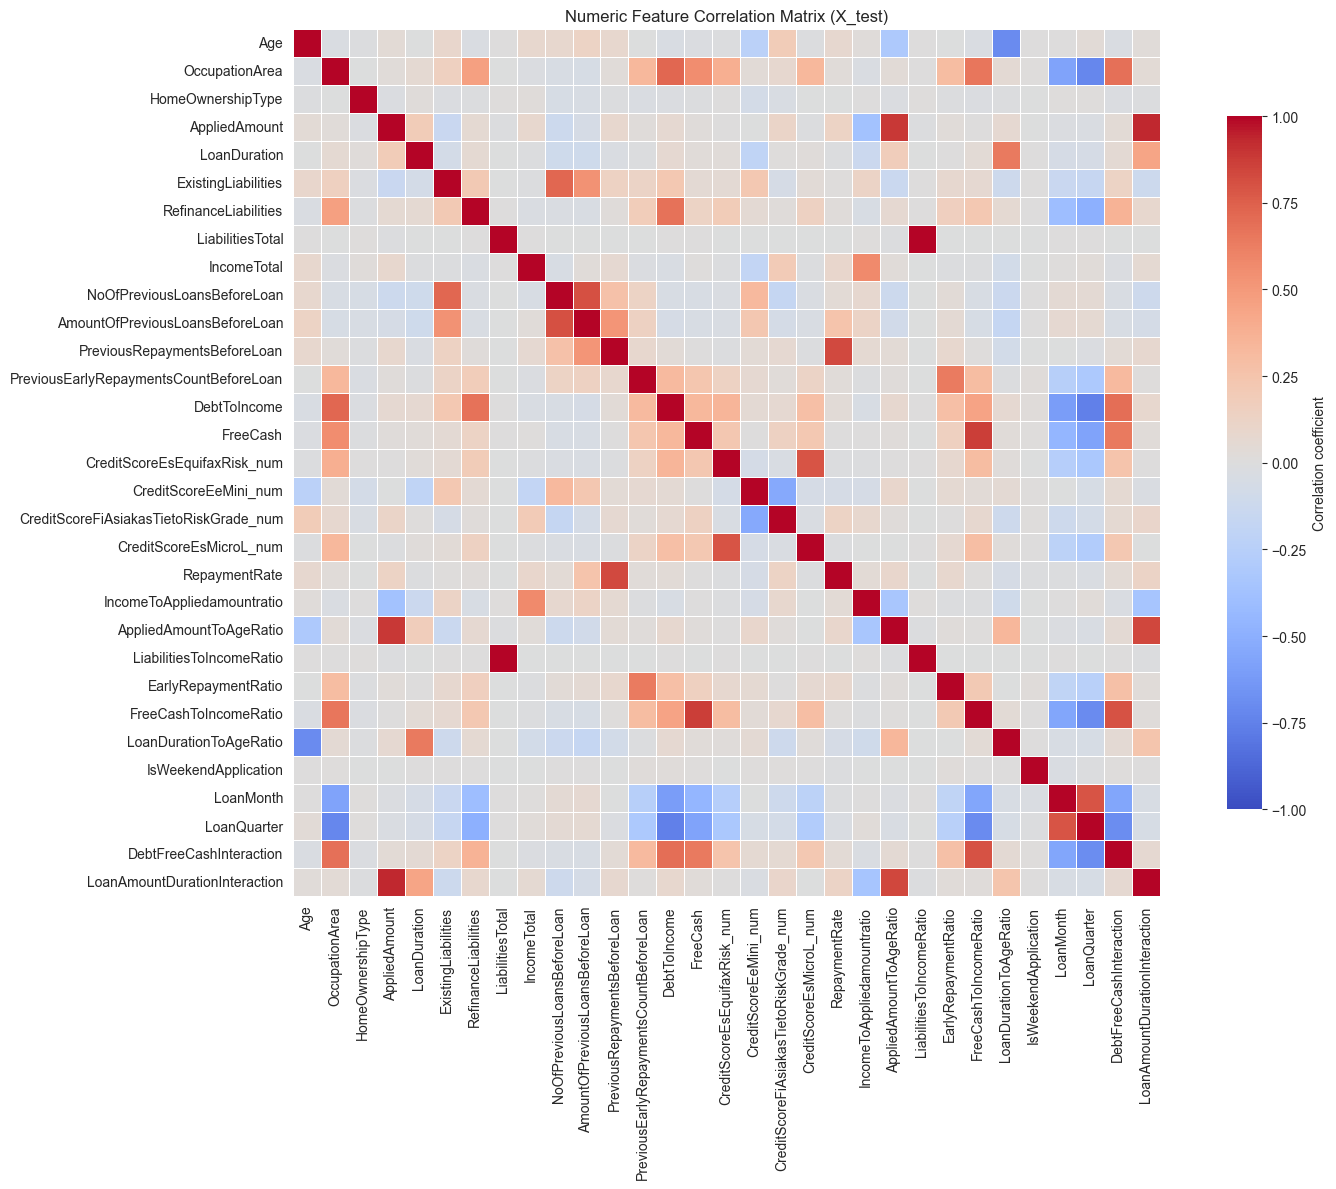

In [17]:
num_cols     = X_test.select_dtypes(include=[np.number]).columns
corr_matrix  = X_test[num_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    vmin=-1, vmax=1, center=0,
    square=True, linewidths=.5,
    cbar_kws={"label": "Correlation coefficient", "shrink": .8}
)
plt.title("Numeric Feature Correlation Matrix (X_test)")
plt.tight_layout()
plt.show()

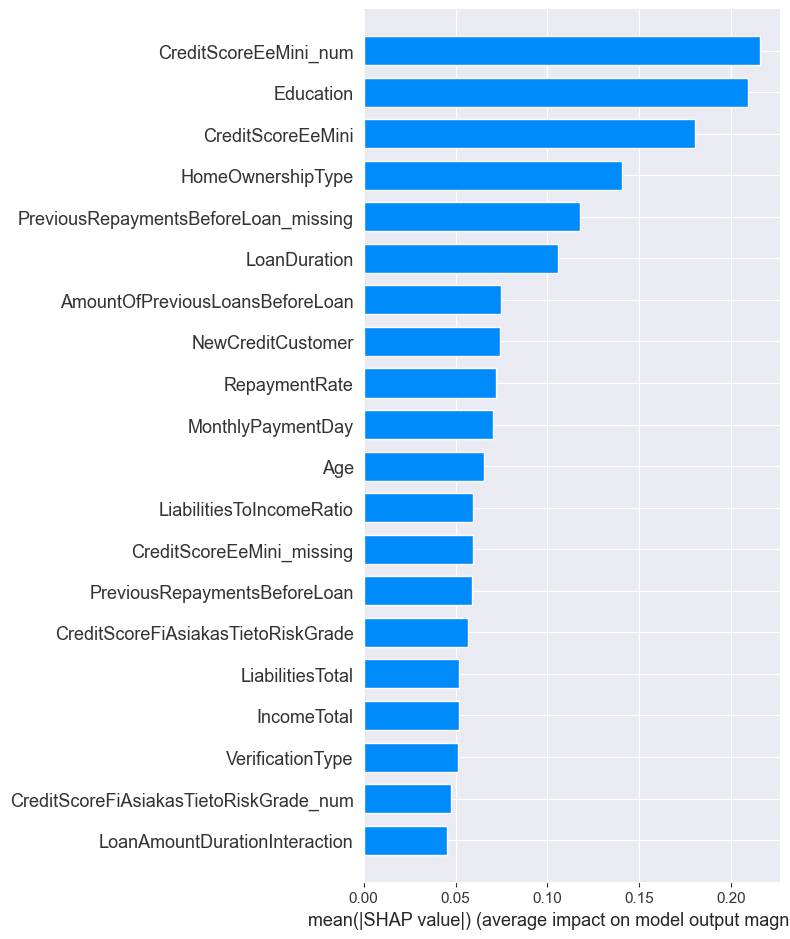

In [18]:
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

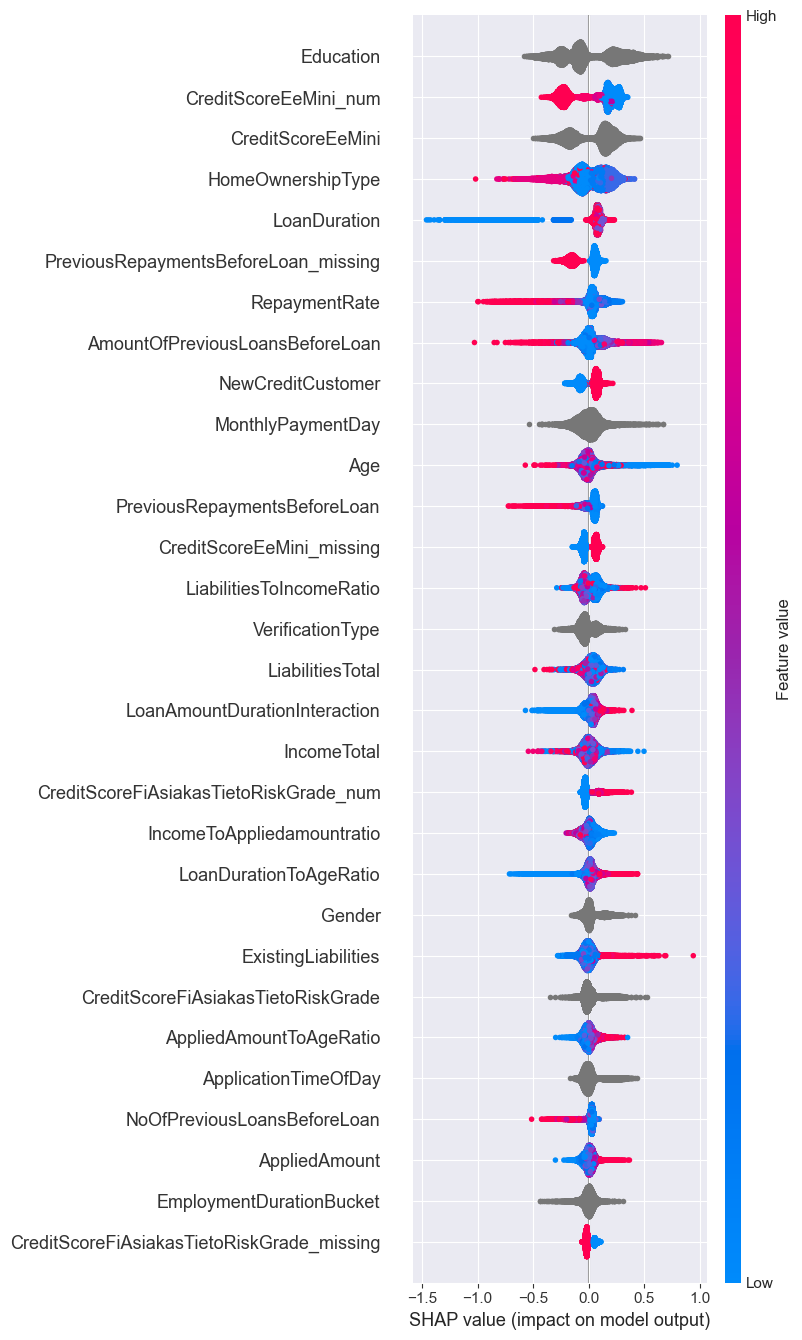

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, max_display= 30)

In [20]:
# Calculate the average absolute SHAP value for each feature on the test set
avg_shap_values = np.abs(shap_values).mean(axis=0)
avg_shap_df = pd.DataFrame({
    'feature': X_test.columns,
    'avg_abs_shap': avg_shap_values
}).sort_values('avg_abs_shap', ascending=False)

print(avg_shap_df)

                                           feature  avg_abs_shap
2                                        Education      0.217571
31                           CreditScoreEeMini_num      0.208987
23                               CreditScoreEeMini      0.181133
4                                HomeOwnershipType      0.136397
6                                     LoanDuration      0.122385
25            PreviousRepaymentsBeforeLoan_missing      0.106630
37                                   RepaymentRate      0.091936
15                 AmountOfPreviousLoansBeforeLoan      0.085581
18                               NewCreditCustomer      0.073267
9                                MonthlyPaymentDay      0.071187
0                                              Age      0.069507
16                    PreviousRepaymentsBeforeLoan      0.061875
32                       CreditScoreEeMini_missing      0.058166
40                        LiabilitiesToIncomeRatio      0.057232
7                        

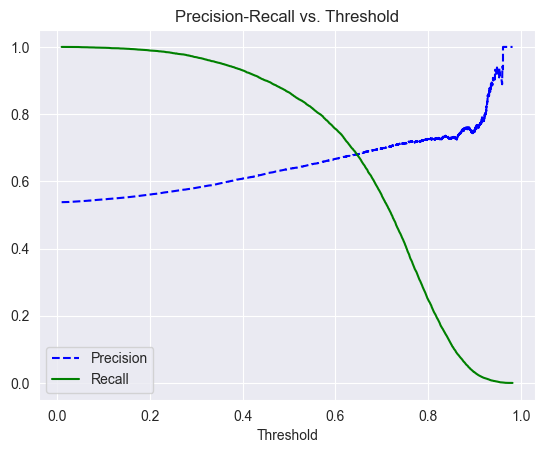

In [21]:
# Get probabilities for the positive class
test_pred_probs = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, test_pred_probs)

plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.title("Precision-Recall vs. Threshold")
plt.grid(True)
plt.show()